# Analyzing IMDB Data in Keras

In [1]:
# Imports
import numpy as np
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.backend import eval
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

Using TensorFlow backend.


## 1. Loading the data
This dataset comes preloaded with Keras, so one simple command will get us training and testing data. There is a parameter for how many words we want to look at. We've set it at 1000, but feel free to experiment.

In [2]:
# Loading the data (it's preloaded in Keras)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=1000)

print(x_train.shape)
print(x_test.shape)

(25000,)
(25000,)


### 1. A. Combine test and training data so we can filter out noise
Use log polarization metric from Trask's Sentiment NN

In [3]:
from collections import Counter

positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

x_total = np.concatenate((x_train,x_test))
y_total = np.concatenate((y_train,y_test))
for idx, review in np.ndenumerate(x_total):
    for word in review:
        if y_total[idx[0]] == 0:
            positive_counts[word] +=1
            total_counts[word] +=1
        elif y_total[idx[0]] == 1:
            negative_counts[word] +=1
            total_counts[word] +=1

# Build Ratios
min_count = 10
pos_neg_ratios = Counter()

for word, count in list(total_counts.most_common()):
    if count > min_count:
        ratio = positive_counts[word] / float(negative_counts[word]+1)
        if ratio > 1:
            pos_neg_ratios[word] = np.log(ratio)
        else:
            pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

print(len(pos_neg_ratios))

998


### 1. B. Distribution of Ratios
Now, examine the distribution of ratios

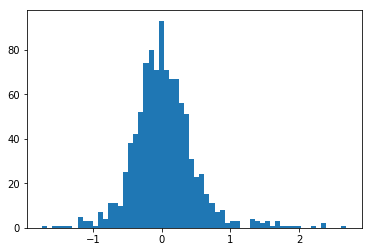

In [4]:
plt.hist(list(pos_neg_ratios.values()), bins=60)
plt.show()

Let's cutoff the words with an absolute value of <= 1 STD (STD = 0.47)

In [5]:
polarity_cutoff = np.std(list(pos_neg_ratios.values())) * .75
print('Polarity Cutoff = ', polarity_cutoff)
max_review = 0
max_new = 0
print('Sample Review before: ',x_total[150])
for idx, review in np.ndenumerate(x_total):
    max_review = max(max_review,len(review))
    new_review = []
    for word in review:
        if np.abs(pos_neg_ratios[word]) > polarity_cutoff:
            new_review.append(word)
    x_total[idx] = new_review
    max_new = max(max_new,len(new_review))
print('Old maximum review length =', max_review)
print('New maximum review length =', max_new)
print('Sample Review after: ',x_total[150])


Polarity Cutoff =  0.235159119556
Sample Review before:  [1, 5, 14, 9, 6, 55, 2, 22, 13, 203, 30, 355, 21, 14, 9, 4, 236, 22, 121, 13, 2, 2, 2, 35, 779, 284, 37, 2, 4, 217, 5, 2, 6, 749, 10, 10, 2, 2, 5, 2, 2, 26, 82, 321, 36, 26, 2, 5, 2, 2, 2, 8, 358, 4, 704, 117, 122, 36, 124, 51, 62, 593, 375, 10, 10, 4, 2, 5, 732, 26, 821, 5, 2, 14, 16, 159, 4, 504, 7, 2, 2, 10, 10, 51, 9, 91, 2, 44, 14, 22, 9, 4, 192, 15, 2, 40, 14, 131, 2, 11, 938, 704, 2, 131, 2, 543, 84, 12, 9, 220, 6, 2, 5, 6, 320, 237, 4, 2, 325, 10, 10, 25, 80, 358, 14, 22, 12, 16, 814, 11, 4, 2, 2, 7, 2, 2, 63, 131, 2, 43, 92, 2, 501, 15, 8, 2, 2, 15, 2, 131, 47, 24, 77, 2, 237, 2, 2, 158, 158]
Old maximum review length = 2494
New maximum review length = 353
Sample Review after:  [55, 203, 355, 779, 217, 82, 321, 36, 358, 704, 36, 62, 821, 40, 131, 938, 704, 131, 543, 320, 325, 80, 358, 131, 43, 92, 501, 131]


In [6]:
xmax = 0
for x in x_total:
    xmax = max(xmax,len(x))
print('Maximum length=',xmax)
num_words = xmax

Maximum length= 353


### Split it up again

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size = 0.5, random_state=42)

## 2. Examining the data
Notice that the data has been already pre-processed, where all the words have numbers, and the reviews come in as a vector with the words that the review contains. For example, if the word 'the' is the first one in our dictionary, and a review contains the word 'the', then there is a 1 in the corresponding vector.

The output comes as a vector of 1's and 0's, where 1 is a positive sentiment for the review, and 0 is negative.

In [8]:
print(x_train[0])
print(y_train[0])

[308, 321, 488, 20, 403, 92, 128, 100, 20, 488, 55, 406, 48, 897, 217, 988, 670, 87, 257, 257, 696, 389, 262, 922, 81, 403, 299, 452, 153, 100, 20]
1


## 3. One-hot encoding the output
Here, we'll turn the input vectors into (0,1)-vectors. For example, if the pre-processed vector contains the number 14, then in the processed vector, the 14th entry will be 1.

In [9]:
# One-hot encoding the output into vector mode, each of length 1000
tokenizer = Tokenizer(num_words=num_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print(x_train[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

And we'll also one-hot encode the output.

In [10]:
# One-hot encoding the output
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(25000, 353) (25000, 2)
(25000, 353) (25000, 2)


## 4. Building the  model architecture
Build a model here using sequential. Feel free to experiment with different layers and sizes! Also, experiment adding dropout to reduce overfitting.

In [11]:
print(num_words)
print(x_train.shape)

353
(25000, 353)


In [12]:
# TODO: Build the model architecture
# Building the model
model = Sequential()
model.add(Dense(int(num_words), activation='tanh', input_dim=num_words))
#model.add(Dropout(.2))
model.add(Dense(num_words, activation='tanh'))
#model.add(Dropout(.2))
#model.add(Dense(num_words, activation='relu'))
#model.add(Dropout(.1))
model.add(Dense(num_classes, activation='softmax'))

# TODO: Compile the model using a loss function and an optimizer.
#sgd = optimizers.SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
opt = optimizers.RMSprop(lr=1e-4)
#model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 353)               124962    
_________________________________________________________________
dense_2 (Dense)              (None, 353)               124962    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 708       
Total params: 250,632
Trainable params: 250,632
Non-trainable params: 0
_________________________________________________________________


## 5. Training the model
Run the model here. Experiment with different batch_size, and number of epochs!

In [13]:
# TODO: Run the model. Feel free to experiment with different batch sizes and number of epochs.
epochs = 150
batch_size = 50

hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/150
25000/25000 [==============================] - 5s - loss: 0.4845 - acc: 0.7656     
Epoch 2/150
25000/25000 [==============================] - 3s - loss: 0.4572 - acc: 0.7829     
Epoch 3/150
25000/25000 [==============================] - 3s - loss: 0.4570 - acc: 0.7852     
Epoch 4/150
25000/25000 [==============================] - 3s - loss: 0.4563 - acc: 0.7858     
Epoch 5/150
25000/25000 [==============================] - 3s - loss: 0.4556 - acc: 0.7859     
Epoch 6/150
25000/25000 [==============================] - 3s - loss: 0.4550 - acc: 0.7865     
Epoch 7/150
25000/25000 [==============================] - 3s - loss: 0.4542 - acc: 0.7868     
Epoch 8/150
25000/25000 [==============================] - 3s - loss: 0.4537 - acc: 0.7865     
Epoch 9/150
25000/25000 [==============================] - 3s - loss: 0.4528 - acc: 0.7872     
Epoch 10/150
25000/25000 [==============================] - 3s - loss: 0.4521 - acc: 0.7880     
Epoch 11/150
25000/25000 [=============

Plot Historical Loss

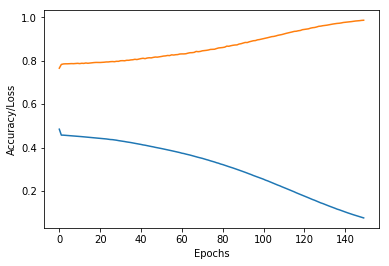

In [14]:
hist.history
x = np.arange(epochs)
yloss = hist.history['loss']
yacc = hist.history['acc']

plt.plot(x,yloss)
plt.plot(x,yacc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()

## 6. Evaluating the model
This will give you the accuracy of the model, as evaluated on the testing set. Can you get something over 85%?

In [15]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: ", score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", score[1])
print("Epochs:", epochs, " Batch Size:",batch_size, " Learning Rate:", eval(model.optimizer.lr))

Train Accuracy:  0.98804
Test Accuracy:  0.746
Epochs: 150  Batch Size: 50  Learning Rate: 0.0001


In [16]:
score

[0.80473467105865482, 0.746]

## Solution

# Building the model architecture with one layer of length 100
smodel = Sequential()
smodel.add(Dense(512, activation='relu', input_dim=num_words))
smodel.add(Dropout(0.3))
smodel.add(Dense(num_classes, activation='softmax'))
smodel.summary()

# Compiling the model using categorical_crossentropy loss, and rmsprop optimizer.
smodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Running and evaluating the model
hist = smodel.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test), 
          verbose=2)

sscore = smodel.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: ", sscore[1])
sscore = smodel.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", sscore[1])